🚀 Iniciando análisis adaptativo de recuperaciones...
🚀 Iniciando recolección adaptable desde: C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\data\raw\matchcenter\MatchCenter\Competition\Season
🔍 Buscando directorios de partidos en: C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\data\raw\matchcenter\MatchCenter\Competition\Season
✅ Directorio de partido encontrado: C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\data\raw\matchcenter\MatchCenter\Competition\Season\20250815_Girona_vs_Rayo_Vallecano_1913916\csv
   Archivos CSV: ['events.csv', 'events_defensive.csv', 'events_gk_actions.csv', 'events_passes.csv', 'events_shots.csv']
✅ Directorio de partido encontrado: C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\data\raw\matchcenter\MatchCenter\Competition\Season\20250815_Villarreal_vs_Real_Oviedo_1913892\csv
   Archivos CSV: ['events.csv', 'events_defensive.csv', 'events_gk_actions.csv', 'events_passes.csv', 'events_shots.csv']
✅ Directorio de partido encontrado

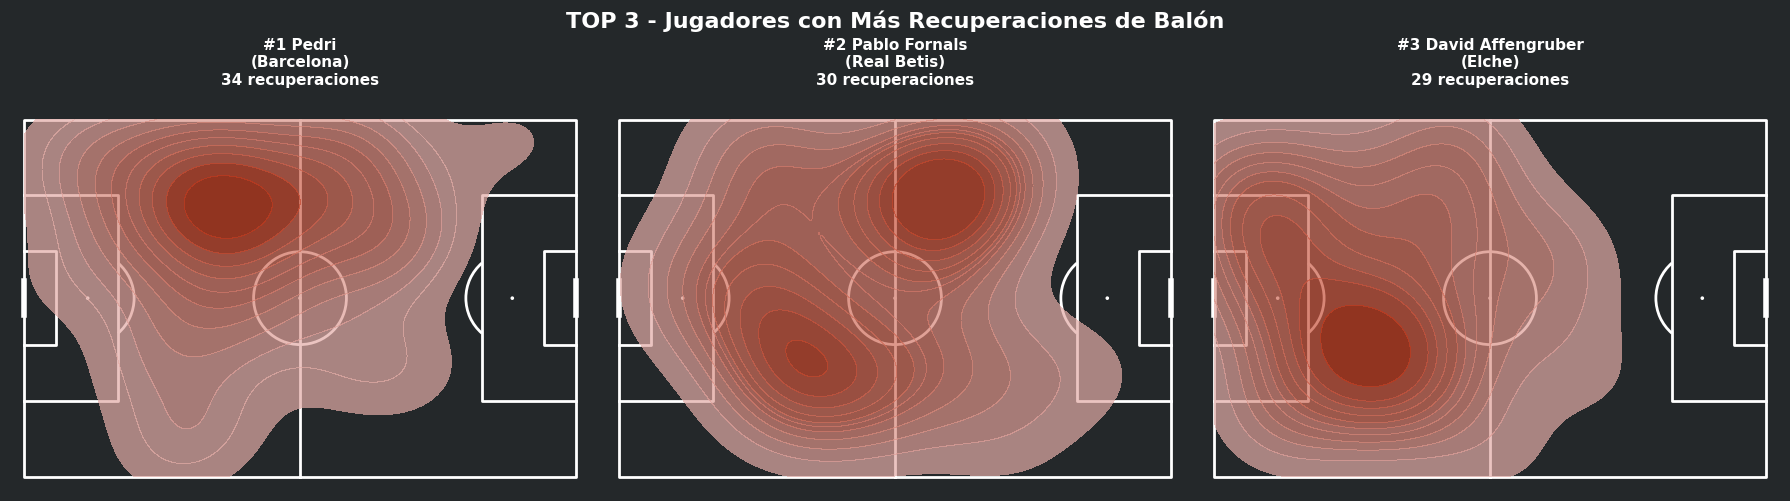


✅ ¡Completado exitosamente!

🎯 Ejemplo - Mapa individual para: Pedri
💾 Imagen guardada: C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\assets\viz\recuperaciones_Pedri.png


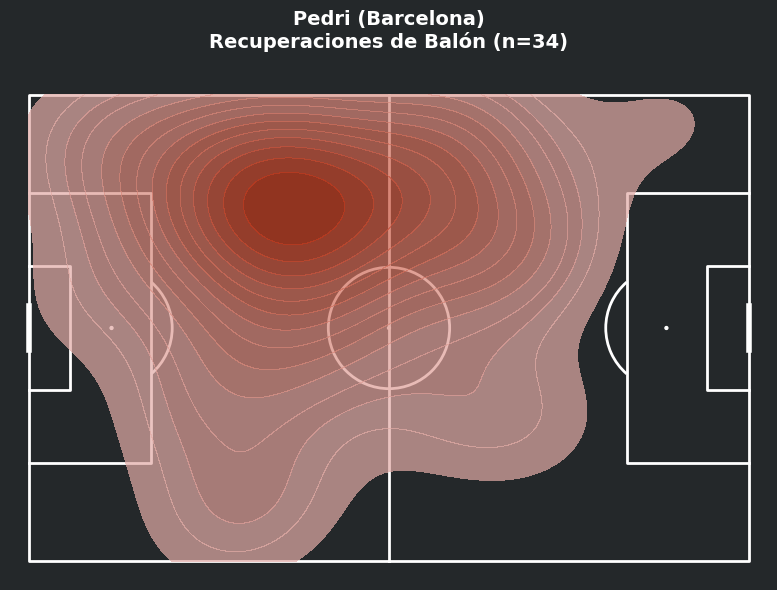

✅ Notebook adaptativo listo!


In [30]:
# Notebook Automatizado - Mapas de Calor de Recuperaciones (Versión Adaptable)
# ==============================================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mplsoccer import Pitch
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# =====================================================================
# CONFIGURACIÓN GLOBAL
# =====================================================================

# ACTUALIZA ESTA RUTA según lo que encuentre el diagnóstico
BASE_DIR = Path(r"C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\data\raw\matchcenter\MatchCenter\Competition\Season")
SAVE_PATH = Path(r"C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\assets\viz")

# Configuración visual
PITCH_COLOR = "#24282a"
LINE_COLOR = "white"
flamingo_cmap = LinearSegmentedColormap.from_list("Flamingo - 10 colors", ['#e3aca7', '#c03a1d'], N=10)

# Crear directorio de salida si no existe
SAVE_PATH.mkdir(parents=True, exist_ok=True)

# =====================================================================
# FUNCIONES DE DETECCIÓN AUTOMÁTICA DE ESTRUCTURA
# =====================================================================

def find_match_directories(base_path, max_depth=5):
    """
    Busca directorios que contienen archivos CSV de partidos.
    Detecta automáticamente la estructura sin importar la profundidad.
    """
    match_dirs = []
    
    def explore_recursive(path, current_depth=0):
        if current_depth > max_depth or not path.is_dir():
            return
            
        try:
            # Buscar archivos CSV en este directorio
            csv_files = [f for f in path.iterdir() if f.is_file() and f.suffix.lower() == '.csv']
            
            # Si encuentra CSVs, verificar si son archivos de partidos
            if csv_files:
                csv_names = [f.name.lower() for f in csv_files]
                
                # Buscar patrones que indiquen archivos de eventos/jugadores
                has_events = any('event' in name or 'defensive' in name for name in csv_names)
                has_players = any('player' in name for name in csv_names)
                
                if has_events or has_players or len(csv_files) > 3:  # Criterio flexible
                    match_dirs.append(path)
                    print(f"✅ Directorio de partido encontrado: {path}")
                    print(f"   Archivos CSV: {[f.name for f in csv_files[:5]]}")
            
            # Continuar explorando subdirectorios
            for subdir in path.iterdir():
                if subdir.is_dir():
                    explore_recursive(subdir, current_depth + 1)
                    
        except (PermissionError, OSError) as e:
            print(f"⚠️  Sin acceso a {path}: {e}")
    
    print(f"🔍 Buscando directorios de partidos en: {base_path}")
    explore_recursive(base_path)
    
    return match_dirs

def smart_find_csv(directory, patterns):
    """
    Busca archivos CSV usando múltiples patrones de nombres.
    """
    if not directory.is_dir():
        return None
    
    for pattern in patterns:
        # Búsqueda exacta
        exact_file = directory / f"{pattern}.csv"
        if exact_file.exists():
            return exact_file
        
        # Búsqueda por contenido en el nombre
        for file in directory.iterdir():
            if (file.is_file() and 
                file.suffix.lower() == '.csv' and 
                pattern.lower() in file.name.lower()):
                return file
    
    return None

def smart_read_players_csv(csv_path):
    """
    Lee un CSV de jugadores y trata de normalizar las columnas automáticamente.
    """
    try:
        df = pd.read_csv(csv_path)
        print(f"📊 Leyendo jugadores: {csv_path.name} ({df.shape[0]} filas, {df.shape[1]} columnas)")
        
        # Mostrar columnas disponibles
        print(f"   Columnas: {list(df.columns)}")
        
        # Mapeo inteligente de columnas
        col_mapping = {}
        cols_lower = {col.lower().strip(): col for col in df.columns}
        
        # Buscar ID del jugador
        for pattern in ['player_id', 'playerid', 'id', 'player id']:
            if pattern in cols_lower:
                col_mapping['player_id'] = cols_lower[pattern]
                break
        
        # Buscar nombre del jugador
        for pattern in ['player_name', 'name', 'player', 'playername', 'player name']:
            if pattern in cols_lower:
                col_mapping['player_name'] = cols_lower[pattern]
                break
        
        # Buscar ID del equipo
        for pattern in ['team_id', 'teamid', 'team id']:
            if pattern in cols_lower:
                col_mapping['team_id'] = cols_lower[pattern]
                break
        
        # Buscar nombre del equipo
        for pattern in ['team_name', 'team', 'teamname', 'team name']:
            if pattern in cols_lower:
                col_mapping['team_name'] = cols_lower[pattern]
                break
        
        print(f"   Mapeo detectado: {col_mapping}")
        
        if 'player_id' not in col_mapping or 'player_name' not in col_mapping:
            print(f"⚠️  Columnas esenciales no encontradas en {csv_path.name}")
            return None
        
        # Crear DataFrame normalizado
        result = pd.DataFrame()
        result['player_id'] = pd.to_numeric(df[col_mapping['player_id']], errors='coerce')
        result['player_name'] = df[col_mapping['player_name']].astype(str)
        
        if 'team_id' in col_mapping:
            result['team_id'] = pd.to_numeric(df[col_mapping['team_id']], errors='coerce')
        
        if 'team_name' in col_mapping:
            result['team_name'] = df[col_mapping['team_name']].astype(str)
        
        # Limpiar datos
        result = result.dropna(subset=['player_id'])
        result['player_id'] = result['player_id'].astype(int)
        
        return result
        
    except Exception as e:
        print(f"❌ Error leyendo {csv_path}: {e}")
        return None

def smart_read_events_csv(csv_path):
    """
    Lee un CSV de eventos y trata de normalizar las columnas automáticamente.
    """
    try:
        df = pd.read_csv(csv_path)
        print(f"📊 Leyendo eventos: {csv_path.name} ({df.shape[0]} filas, {df.shape[1]} columnas)")
        
        # Mostrar muestra de datos
        print(f"   Columnas: {list(df.columns)}")
        if len(df) > 0:
            print(f"   Muestra: {df.iloc[0].to_dict()}")
        
        # Mapeo inteligente de columnas
        col_mapping = {}
        cols_lower = {col.lower().strip(): col for col in df.columns}
        
        # Coordenadas
        for pattern in ['x']:
            if pattern in cols_lower:
                col_mapping['x'] = cols_lower[pattern]
                break
        
        for pattern in ['y']:
            if pattern in cols_lower:
                col_mapping['y'] = cols_lower[pattern]
                break
        
        # ID del jugador
        for pattern in ['playerid', 'player_id', 'player id']:
            if pattern in cols_lower:
                col_mapping['playerId'] = cols_lower[pattern]
                break
        
        # Tipo de evento
        for pattern in ['typename', 'type', 'event', 'eventname', 'type name', 'event name']:
            if pattern in cols_lower:
                col_mapping['typeName'] = cols_lower[pattern]
                break
        
        # ID del equipo
        for pattern in ['teamid', 'team_id', 'team id']:
            if pattern in cols_lower:
                col_mapping['teamId'] = cols_lower[pattern]
                break
        
        print(f"   Mapeo detectado: {col_mapping}")
        
        # Verificar columnas esenciales
        required = ['x', 'y', 'playerId']
        missing = [col for col in required if col not in col_mapping]
        
        if missing:
            print(f"⚠️  Columnas esenciales faltantes: {missing}")
            return None
        
        # Crear DataFrame normalizado
        result = pd.DataFrame()
        result['x'] = pd.to_numeric(df[col_mapping['x']], errors='coerce')
        result['y'] = pd.to_numeric(df[col_mapping['y']], errors='coerce')
        result['playerId'] = pd.to_numeric(df[col_mapping['playerId']], errors='coerce')
        
        if 'typeName' in col_mapping:
            result['typeName'] = df[col_mapping['typeName']].astype(str)
        
        if 'teamId' in col_mapping:
            result['teamId'] = pd.to_numeric(df[col_mapping['teamId']], errors='coerce')
        
        # Limpiar datos
        result = result.dropna(subset=['x', 'y', 'playerId'])
        
        return result
        
    except Exception as e:
        print(f"❌ Error leyendo {csv_path}: {e}")
        return None

# =====================================================================
# FUNCIÓN PRINCIPAL DE RECOLECCIÓN (MEJORADA)
# =====================================================================

def collect_ball_recoveries_adaptive(base_dir):
    """
    Versión adaptable que detecta automáticamente la estructura de directorios.
    """
    print(f"🚀 Iniciando recolección adaptable desde: {base_dir}")
    
    # Buscar directorios de partidos automáticamente
    match_dirs = find_match_directories(base_dir)
    
    if not match_dirs:
        raise RuntimeError(f"No se encontraron directorios con archivos CSV en {base_dir}")
    
    print(f"📁 Encontrados {len(match_dirs)} directorios de partidos")
    
    all_recoveries = []
    all_players = []
    
    for i, match_dir in enumerate(match_dirs):
        print(f"\n📂 Procesando {i+1}/{len(match_dirs)}: {match_dir.name}")
        
        # Buscar archivo de jugadores con múltiples patrones
        players_patterns = ['players', 'player', 'roster', 'lineup']
        players_file = smart_find_csv(match_dir, players_patterns)
        
        if not players_file:
            print(f"   ⚠️  No se encontró archivo de jugadores")
            continue
        
        players_df = smart_read_players_csv(players_file)
        if players_df is None:
            continue
        
        # Buscar archivo de eventos con múltiples patrones
        events_patterns = ['events_defensive', 'defensive', 'events', 'event', 'actions']
        events_file = smart_find_csv(match_dir, events_patterns)
        
        if not events_file:
            print(f"   ⚠️  No se encontró archivo de eventos")
            continue
        
        events_df = smart_read_events_csv(events_file)
        if events_df is None:
            continue
        
        # Filtrar recuperaciones (con múltiples patrones)
        if 'typeName' in events_df.columns:
            recovery_patterns = ['ballrecovery', 'ball recovery', 'recovery', 'recuperacion']
            recovery_mask = events_df['typeName'].str.lower().isin(recovery_patterns)
            recoveries = events_df[recovery_mask]
        else:
            print(f"   ⚠️  No se encontró columna de tipo de evento, usando todos los eventos")
            recoveries = events_df
        
        if recoveries.empty:
            print(f"   ⚠️  No se encontraron recuperaciones")
            continue
        
        # Añadir información de jugadores
        recoveries_with_players = recoveries.merge(
            players_df, 
            left_on='playerId', 
            right_on='player_id', 
            how='left'
        )
        
        all_recoveries.append(recoveries_with_players)
        all_players.append(players_df)
        
        print(f"   ✅ {len(recoveries)} recuperaciones procesadas")
    
    if not all_recoveries:
        raise RuntimeError("No se encontraron recuperaciones en ningún partido")
    
    # Combinar todos los datos
    combined_recoveries = pd.concat(all_recoveries, ignore_index=True)
    combined_players = pd.concat(all_players, ignore_index=True).drop_duplicates(subset=['player_id'])
    
    # Crear ranking
    ranking = (combined_recoveries
               .groupby(['player_id', 'player_name'])
               .agg({
                   'playerId': 'count',
                   'team_name': 'first'
               })
               .rename(columns={'playerId': 'recoveries'})
               .reset_index()
               .sort_values('recoveries', ascending=False))
    
    print(f"\n✅ Procesamiento completado:")
    print(f"   📊 Total recuperaciones: {len(combined_recoveries)}")
    print(f"   👥 Jugadores únicos: {len(ranking)}")
    
    return combined_recoveries, ranking

# =====================================================================
# FUNCIONES DE VISUALIZACIÓN (ADAPTADAS)
# =====================================================================

def plot_individual_recovery_heatmap_adaptive(recoveries_df, player_name, save_image=True, show_plot=True, figsize=(10, 6)):
    """
    Versión adaptada de la función de mapa individual con KDE suave.
    """
    # Buscar jugador
    player_mask = recoveries_df['player_name'].str.lower() == player_name.lower()
    player_data = recoveries_df[player_mask]
    
    if player_data.empty:
        available = recoveries_df['player_name'].value_counts().head(10)
        raise ValueError(f"Jugador '{player_name}' no encontrado.\n"
                        f"Jugadores disponibles (top 10):\n{available}")
    
    # Información del jugador
    player_info = player_data.iloc[0]
    team_name = player_info.get('team_name', 'Unknown')
    total_recoveries = len(player_data)
    
    # Crear visualización con campo horizontal
    pitch = Pitch(pitch_type='opta', pitch_color=PITCH_COLOR, line_color=LINE_COLOR, 
                 axis=False)
    fig, ax = pitch.draw(figsize=figsize)
    
    # Usar KDE para mapa de calor suave (como en tu ejemplo)
    if len(player_data) >= 5:  # Necesitamos suficientes puntos para KDE
        pitch.kdeplot(player_data['x'], player_data['y'], ax=ax, 
                     cmap=flamingo_cmap, fill=True, levels=15, alpha=0.7,
                     thresh=0.05)
    else:
        # Si hay pocos puntos, usar scatter
        pitch.scatter(player_data['x'], player_data['y'], ax=ax, 
                     s=200, c='#c03a1d', alpha=0.8, edgecolors='white', linewidth=1)
    
    # Título más elegante
    title = f"{player_name} ({team_name})\nRecuperaciones de Balón (n={total_recoveries})"
    ax.set_title(title, color=LINE_COLOR, fontsize=14, pad=20, 
                fontweight='bold')
    fig.patch.set_facecolor(PITCH_COLOR)
    
    # Guardar
    if save_image:
        safe_name = player_name.replace(" ", "_").replace(".", "")
        filename = f"recuperaciones_{safe_name}.png"
        filepath = SAVE_PATH / filename
        plt.savefig(filepath, dpi=300, bbox_inches='tight', 
                   facecolor=PITCH_COLOR, edgecolor='none')
        print(f"💾 Imagen guardada: {filepath}")
    
    if show_plot:
        plt.show()
    
    return fig, ax

def plot_top3_recovery_heatmaps_adaptive(recoveries_df, ranking_df, save_image=True, show_plot=True):
    """
    Versión adaptada para TOP 3 con KDE suave.
    """
    top3 = ranking_df.head(3)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.patch.set_facecolor(PITCH_COLOR)
    
    for i, (_, player) in enumerate(top3.iterrows()):
        player_id = player['player_id']
        player_name = player['player_name']
        team_name = player.get('team_name', 'Unknown')
        recoveries_count = player['recoveries']
        
        # Filtrar datos del jugador
        player_data = recoveries_df[recoveries_df['player_id'] == player_id]
        
        # Crear pitch
        pitch = Pitch(pitch_type='opta', pitch_color=PITCH_COLOR, 
                     line_color=LINE_COLOR, axis=False)
        pitch.draw(ax=axes[i])
        
        # Mapa de calor suave con KDE
        if not player_data.empty and len(player_data) >= 5:
            pitch.kdeplot(player_data['x'], player_data['y'], ax=axes[i], 
                         cmap=flamingo_cmap, fill=True, levels=12, alpha=0.7,
                         thresh=0.05)
        elif not player_data.empty:
            # Scatter para pocos puntos
            pitch.scatter(player_data['x'], player_data['y'], ax=axes[i], 
                         s=150, c='#c03a1d', alpha=0.8, 
                         edgecolors='white', linewidth=1)
        
        # Título más elegante
        title = f"#{i+1} {player_name}\n({team_name})\n{recoveries_count} recuperaciones"
        axes[i].set_title(title, color=LINE_COLOR, fontsize=11, pad=15,
                         fontweight='bold')
    
    # Título general más elegante
    fig.suptitle("TOP 3 - Jugadores con Más Recuperaciones de Balón", 
                color=LINE_COLOR, fontsize=16, y=0.95, fontweight='bold')
    plt.tight_layout()
    
    if save_image:
        filepath = SAVE_PATH / "top3_recuperaciones.png"
        plt.savefig(filepath, dpi=300, bbox_inches='tight', 
                   facecolor=PITCH_COLOR, edgecolor='none')
        print(f"💾 TOP 3 guardado: {filepath}")
    
    if show_plot:
        plt.show()
    
    return fig

# =====================================================================
# FUNCIÓN PRINCIPAL ADAPTADA
# =====================================================================

def main_adaptive():
    """
    Función principal que se adapta automáticamente a la estructura de datos.
    """
    try:
        print("🚀 Iniciando análisis adaptativo de recuperaciones...")
        print("=" * 60)
        
        # Verificar que el directorio base existe
        if not BASE_DIR.exists():
            print(f"❌ El directorio base no existe: {BASE_DIR}")
            print("Por favor, actualiza BASE_DIR con la ruta correcta")
            return None, None
        
        # Recopilar datos de forma adaptativa
        recoveries_df, ranking_df = collect_ball_recoveries_adaptive(BASE_DIR)
        
        # Estadísticas
        print(f"\n📈 Estadísticas:")
        print(f"   📊 Total recuperaciones: {len(recoveries_df):,}")
        print(f"   👥 Jugadores únicos: {len(ranking_df):,}")
        
        # Mostrar TOP 5
        print(f"\n🏆 TOP 5 Jugadores:")
        for i, (_, player) in enumerate(ranking_df.head(5).iterrows()):
            team = player.get('team_name', 'Unknown')
            print(f"   {i+1}. {player['player_name']} ({team}) - {player['recoveries']} recuperaciones")
        
        # Generar TOP 3
        print(f"\n🎨 Generando TOP 3...")
        plot_top3_recovery_heatmaps_adaptive(recoveries_df, ranking_df)
        
        print(f"\n✅ ¡Completado exitosamente!")
        return recoveries_df, ranking_df
        
    except Exception as e:
        print(f"❌ Error: {e}")
        print("\n💡 Sugerencias:")
        print("1. Ejecuta el código de diagnóstico primero")
        print("2. Verifica que BASE_DIR apunte al directorio correcto")
        print("3. Asegúrate de que los archivos CSV existen")
        raise

# =====================================================================
# EJECUCIÓN
# =====================================================================

if __name__ == "__main__":
    # Ejecutar versión adaptativa
    recoveries_df, ranking_df = main_adaptive()
    
    # Ejemplo de uso individual
    if recoveries_df is not None and not ranking_df.empty:
        top_player = ranking_df.iloc[0]['player_name']
        print(f"\n🎯 Ejemplo - Mapa individual para: {top_player}")
        plot_individual_recovery_heatmap_adaptive(recoveries_df, top_player)

print("✅ Notebook adaptativo listo!")

💾 Imagen guardada: C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\assets\viz\recuperaciones_Sergi_Altimira.png


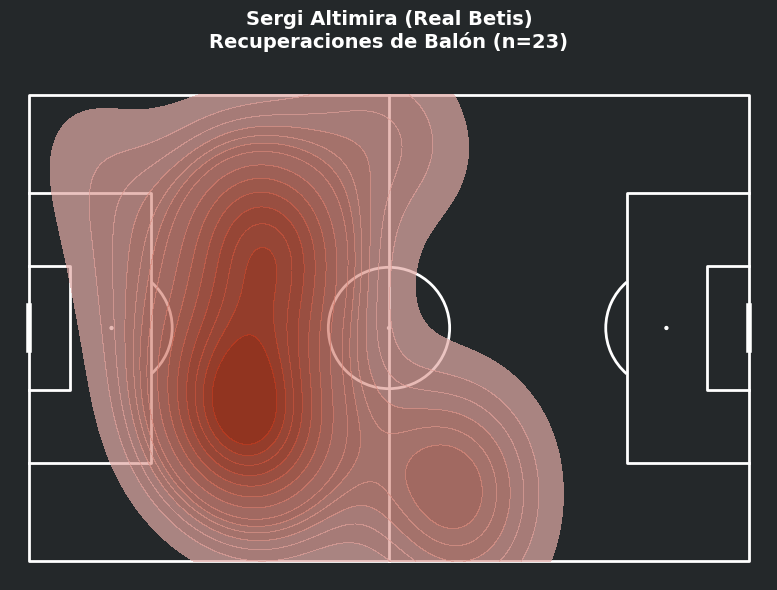

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Sergi Altimira (Real Betis)\nRecuperaciones de Balón (n=23)'}>)

In [31]:
plot_individual_recovery_heatmap_adaptive(recoveries_df, "Sergi Altimira")

🛡️  ANÁLISIS DE ACCIONES DEFENSIVAS
Incluye: Tackles, Intercepciones y Recuperaciones
🚀 Recopilando acciones defensivas desde: C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\data\raw\matchcenter\MatchCenter\Competition\Season
🔍 Buscando directorios de partidos en: C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\data\raw\matchcenter\MatchCenter\Competition\Season
✅ Directorio encontrado: C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\data\raw\matchcenter\MatchCenter\Competition\Season\20250815_Girona_vs_Rayo_Vallecano_1913916\csv
   Archivos CSV: ['events.csv', 'events_defensive.csv', 'events_gk_actions.csv', 'events_passes.csv', 'events_shots.csv']
✅ Directorio encontrado: C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\data\raw\matchcenter\MatchCenter\Competition\Season\20250815_Villarreal_vs_Real_Oviedo_1913892\csv
   Archivos CSV: ['events.csv', 'events_defensive.csv', 'events_gk_actions.csv', 'events_passes.csv', 'events_shots.csv']
✅ Directorio encontrado

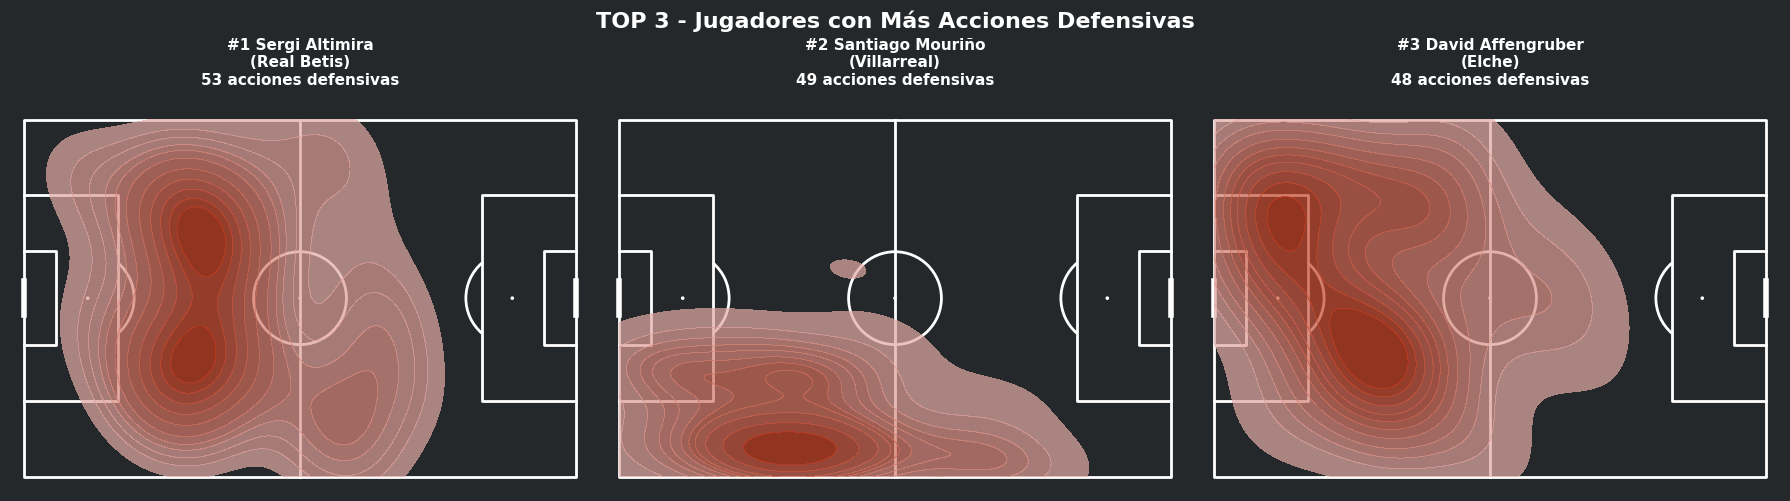


✅ ¡Análisis defensivo completado!

🎯 Ejemplo - Mapa defensivo para: Sergi Altimira
💾 Imagen guardada: C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\assets\viz\acciones_defensivas_Sergi_Altimira.png


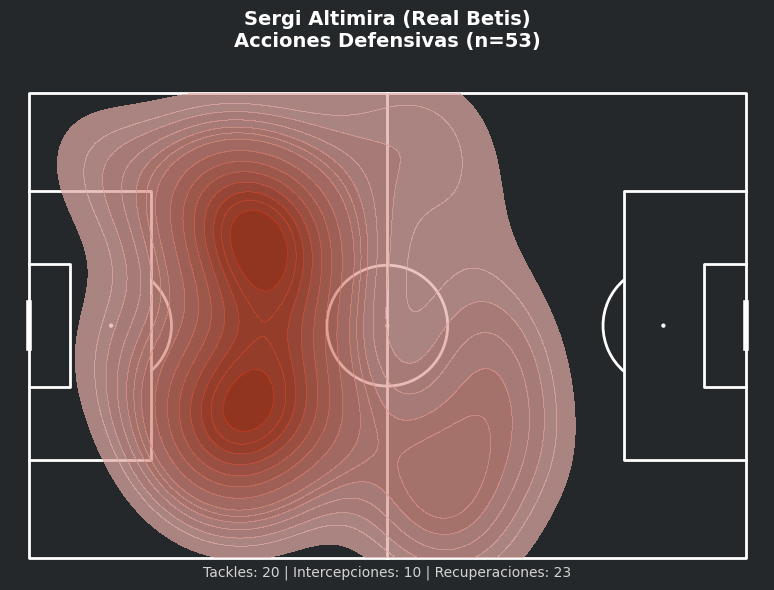


🔍 Búsqueda de jugadores:
🛡️  Mejores jugadores defensivos:
  - Sergi Altimira (Real Betis) - 53 acciones
    → BallRecovery: 23
    → Tackle: 20
    → Interception: 10
  - Santiago Mouriño (Villarreal) - 49 acciones
    → BallRecovery: 26
    → Tackle: 17
    → Interception: 6
  - David Affengruber (Elche) - 48 acciones
    → BallRecovery: 29
    → Tackle: 10
    → Interception: 9
  - Antonio Blanco (Deportivo Alaves) - 47 acciones
    → BallRecovery: 27
    → Tackle: 14
    → Interception: 6
  - Pathé Ciss (Rayo Vallecano) - 46 acciones
    → BallRecovery: 25
    → Tackle: 14
    → Interception: 7
🛡️  ¡Notebook de acciones defensivas listo!
📝 Funciones disponibles:
  - plot_defensive_actions_heatmap(actions_df, 'Nombre Jugador')
  - plot_top3_defensive_actions(actions_df, ranking_df)
  - search_defensive_players(ranking_df, 'término búsqueda')


In [35]:
# Notebook - Mapas de Calor de Acciones Defensivas (Tackles + Intercepciones)
# =============================================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mplsoccer import Pitch
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# =====================================================================
# CONFIGURACIÓN GLOBAL
# =====================================================================

BASE_DIR = Path(r"C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\data\raw\matchcenter\MatchCenter\Competition\Season")
SAVE_PATH = Path(r"C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\assets\viz")

# Configuración visual
PITCH_COLOR = "#24282a"
LINE_COLOR = "white"
flamingo_cmap = LinearSegmentedColormap.from_list("Flamingo - 10 colors", ['#e3aca7', '#c03a1d'], N=10)

# Crear directorio de salida si no existe
SAVE_PATH.mkdir(parents=True, exist_ok=True)

# =====================================================================
# FUNCIONES DE DETECCIÓN PARA ACCIONES DEFENSIVAS
# =====================================================================

def find_match_directories(base_path, max_depth=5):
    """
    Busca directorios que contienen archivos CSV de partidos.
    """
    match_dirs = []
    
    def explore_recursive(path, current_depth=0):
        if current_depth > max_depth or not path.is_dir():
            return
            
        try:
            csv_files = [f for f in path.iterdir() if f.is_file() and f.suffix.lower() == '.csv']
            
            if csv_files:
                csv_names = [f.name.lower() for f in csv_files]
                has_events = any('event' in name or 'defensive' in name for name in csv_names)
                has_players = any('player' in name for name in csv_names)
                
                if has_events or has_players or len(csv_files) > 3:
                    match_dirs.append(path)
                    print(f"✅ Directorio encontrado: {path}")
                    print(f"   Archivos CSV: {[f.name for f in csv_files[:5]]}")
            
            for subdir in path.iterdir():
                if subdir.is_dir():
                    explore_recursive(subdir, current_depth + 1)
                    
        except (PermissionError, OSError) as e:
            print(f"⚠️  Sin acceso a {path}: {e}")
    
    print(f"🔍 Buscando directorios de partidos en: {base_path}")
    explore_recursive(base_path)
    return match_dirs

def smart_find_csv(directory, patterns):
    """Busca archivos CSV usando múltiples patrones de nombres."""
    if not directory.is_dir():
        return None
    
    for pattern in patterns:
        exact_file = directory / f"{pattern}.csv"
        if exact_file.exists():
            return exact_file
        
        for file in directory.iterdir():
            if (file.is_file() and 
                file.suffix.lower() == '.csv' and 
                pattern.lower() in file.name.lower()):
                return file
    return None

def smart_read_players_csv(csv_path):
    """Lee y normaliza CSV de jugadores."""
    try:
        df = pd.read_csv(csv_path)
        print(f"📊 Leyendo jugadores: {csv_path.name} ({df.shape[0]} filas)")
        
        col_mapping = {}
        cols_lower = {col.lower().strip(): col for col in df.columns}
        
        # Mapear columnas esenciales
        for pattern in ['player_id', 'playerid', 'id', 'player id']:
            if pattern in cols_lower:
                col_mapping['player_id'] = cols_lower[pattern]
                break
        
        for pattern in ['player_name', 'name', 'player', 'playername', 'player name']:
            if pattern in cols_lower:
                col_mapping['player_name'] = cols_lower[pattern]
                break
        
        for pattern in ['team_id', 'teamid', 'team id']:
            if pattern in cols_lower:
                col_mapping['team_id'] = cols_lower[pattern]
                break
        
        for pattern in ['team_name', 'team', 'teamname', 'team name']:
            if pattern in cols_lower:
                col_mapping['team_name'] = cols_lower[pattern]
                break
        
        if 'player_id' not in col_mapping or 'player_name' not in col_mapping:
            print(f"⚠️  Columnas esenciales no encontradas")
            return None
        
        result = pd.DataFrame()
        result['player_id'] = pd.to_numeric(df[col_mapping['player_id']], errors='coerce')
        result['player_name'] = df[col_mapping['player_name']].astype(str)
        
        if 'team_id' in col_mapping:
            result['team_id'] = pd.to_numeric(df[col_mapping['team_id']], errors='coerce')
        if 'team_name' in col_mapping:
            result['team_name'] = df[col_mapping['team_name']].astype(str)
        
        result = result.dropna(subset=['player_id'])
        result['player_id'] = result['player_id'].astype(int)
        
        return result
        
    except Exception as e:
        print(f"❌ Error leyendo {csv_path}: {e}")
        return None

def smart_read_defensive_events(csv_path):
    """
    Lee eventos defensivos y filtra TACKLES e INTERCEPCIONES.
    """
    try:
        df = pd.read_csv(csv_path)
        print(f"📊 Leyendo eventos defensivos: {csv_path.name} ({df.shape[0]} filas)")
        
        col_mapping = {}
        cols_lower = {col.lower().strip(): col for col in df.columns}
        
        # Mapear columnas
        for pattern in ['x']:
            if pattern in cols_lower:
                col_mapping['x'] = cols_lower[pattern]
                break
        
        for pattern in ['y']:
            if pattern in cols_lower:
                col_mapping['y'] = cols_lower[pattern]
                break
        
        for pattern in ['playerid', 'player_id', 'player id']:
            if pattern in cols_lower:
                col_mapping['playerId'] = cols_lower[pattern]
                break
        
        for pattern in ['typename', 'type', 'event', 'eventname', 'type name']:
            if pattern in cols_lower:
                col_mapping['typeName'] = cols_lower[pattern]
                break
        
        for pattern in ['teamid', 'team_id', 'team id']:
            if pattern in cols_lower:
                col_mapping['teamId'] = cols_lower[pattern]
                break
        
        required = ['x', 'y', 'playerId']
        missing = [col for col in required if col not in col_mapping]
        
        if missing:
            print(f"⚠️  Columnas faltantes: {missing}")
            return None
        
        result = pd.DataFrame()
        result['x'] = pd.to_numeric(df[col_mapping['x']], errors='coerce')
        result['y'] = pd.to_numeric(df[col_mapping['y']], errors='coerce')
        result['playerId'] = pd.to_numeric(df[col_mapping['playerId']], errors='coerce')
        
        if 'typeName' in col_mapping:
            result['typeName'] = df[col_mapping['typeName']].astype(str)
        if 'teamId' in col_mapping:
            result['teamId'] = pd.to_numeric(df[col_mapping['teamId']], errors='coerce')
        
        result = result.dropna(subset=['x', 'y', 'playerId'])
        
        # FILTRAR TACKLES E INTERCEPCIONES
        if 'typeName' in result.columns:
            defensive_patterns = [
                'tacklewon', 'tackle won', 'tackle', 
                'interceptionwon', 'interception won', 'interception',
                'ballrecovery', 'ball recovery', 'recovery'
            ]
            
            mask = result['typeName'].str.lower().isin(defensive_patterns)
            result = result[mask]
            
            print(f"   ✅ {len(result)} acciones defensivas encontradas")
            
            # Mostrar tipos de eventos encontrados
            event_types = result['typeName'].value_counts()
            print(f"   📋 Tipos de eventos: {dict(event_types)}")
        
        return result
        
    except Exception as e:
        print(f"❌ Error leyendo {csv_path}: {e}")
        return None

# =====================================================================
# FUNCIÓN PRINCIPAL DE RECOLECCIÓN
# =====================================================================

def collect_defensive_actions(base_dir):
    """
    Recopila tackles, intercepciones y recuperaciones de todos los partidos.
    """
    print(f"🚀 Recopilando acciones defensivas desde: {base_dir}")
    
    match_dirs = find_match_directories(base_dir)
    
    if not match_dirs:
        raise RuntimeError(f"No se encontraron directorios con archivos CSV")
    
    print(f"📁 Procesando {len(match_dirs)} directorios de partidos")
    
    all_actions = []
    
    for i, match_dir in enumerate(match_dirs):
        print(f"\n📂 Procesando {i+1}/{len(match_dirs)}: {match_dir.name}")
        
        # Buscar jugadores
        players_patterns = ['players', 'player', 'roster', 'lineup']
        players_file = smart_find_csv(match_dir, players_patterns)
        
        if not players_file:
            print(f"   ⚠️  No se encontró archivo de jugadores")
            continue
        
        players_df = smart_read_players_csv(players_file)
        if players_df is None:
            continue
        
        # Buscar eventos defensivos
        events_patterns = ['events_defensive', 'defensive', 'events', 'event', 'actions']
        events_file = smart_find_csv(match_dir, events_patterns)
        
        if not events_file:
            print(f"   ⚠️  No se encontró archivo de eventos")
            continue
        
        actions_df = smart_read_defensive_events(events_file)
        if actions_df is None:
            continue
        
        if actions_df.empty:
            print(f"   ⚠️  No se encontraron acciones defensivas")
            continue
        
        # Añadir información de jugadores
        actions_with_players = actions_df.merge(
            players_df, 
            left_on='playerId', 
            right_on='player_id', 
            how='left'
        )
        
        all_actions.append(actions_with_players)
        print(f"   ✅ {len(actions_df)} acciones defensivas procesadas")
    
    if not all_actions:
        raise RuntimeError("No se encontraron acciones defensivas en ningún partido")
    
    # Combinar datos
    combined_actions = pd.concat(all_actions, ignore_index=True)
    
    # Crear ranking
    ranking = (combined_actions
               .groupby(['player_id', 'player_name'])
               .agg({
                   'playerId': 'count',
                   'team_name': 'first',
                   'typeName': lambda x: dict(x.value_counts())  # Contar tipos de acciones
               })
               .rename(columns={'playerId': 'total_actions'})
               .reset_index()
               .sort_values('total_actions', ascending=False))
    
    print(f"\n✅ Procesamiento completado:")
    print(f"   📊 Total acciones defensivas: {len(combined_actions)}")
    print(f"   👥 Jugadores únicos: {len(ranking)}")
    
    return combined_actions, ranking

# =====================================================================
# FUNCIONES DE VISUALIZACIÓN
# =====================================================================

def plot_defensive_actions_heatmap(actions_df, player_name, save_image=True, show_plot=True, figsize=(10, 6)):
    """
    Genera mapa de calor de acciones defensivas (tackles + intercepciones + recuperaciones).
    """
    player_mask = actions_df['player_name'].str.lower() == player_name.lower()
    player_data = actions_df[player_mask]
    
    if player_data.empty:
        available = actions_df['player_name'].value_counts().head(10)
        raise ValueError(f"Jugador '{player_name}' no encontrado.\n"
                        f"Jugadores disponibles (top 10):\n{available}")
    
    # Información del jugador
    player_info = player_data.iloc[0]
    team_name = player_info.get('team_name', 'Unknown')
    total_actions = len(player_data)
    
    # Contar tipos de acciones
    action_counts = player_data['typeName'].value_counts().to_dict()
    tackles = sum(v for k, v in action_counts.items() if 'tackle' in k.lower())
    interceptions = sum(v for k, v in action_counts.items() if 'interception' in k.lower())
    recoveries = sum(v for k, v in action_counts.items() if 'recovery' in k.lower())
    
    # Crear pitch
    pitch = Pitch(pitch_type='opta', pitch_color=PITCH_COLOR, line_color=LINE_COLOR, axis=False)
    fig, ax = pitch.draw(figsize=figsize)
    
    # KDE suave
    if len(player_data) >= 5:
        pitch.kdeplot(player_data['x'], player_data['y'], ax=ax, 
                     cmap=flamingo_cmap, fill=True, levels=15, alpha=0.7, thresh=0.05)
    else:
        pitch.scatter(player_data['x'], player_data['y'], ax=ax, 
                     s=200, c='#c03a1d', alpha=0.8, edgecolors='white', linewidth=1)
    
    # Título detallado
    title = f"{player_name} ({team_name})\nAcciones Defensivas (n={total_actions})"
    subtitle = f"Tackles: {tackles} | Intercepciones: {interceptions} | Recuperaciones: {recoveries}"
    
    ax.set_title(title, color=LINE_COLOR, fontsize=14, pad=20, fontweight='bold')
    ax.text(0.5, 0.00, subtitle, transform=ax.transAxes, ha='center', 
            color=LINE_COLOR, fontsize=10, alpha=0.8)
    
    fig.patch.set_facecolor(PITCH_COLOR)
    
    if save_image:
        safe_name = player_name.replace(" ", "_").replace(".", "")
        filename = f"acciones_defensivas_{safe_name}.png"
        filepath = SAVE_PATH / filename
        plt.savefig(filepath, dpi=300, bbox_inches='tight', 
                   facecolor=PITCH_COLOR, edgecolor='none')
        print(f"💾 Imagen guardada: {filepath}")
    
    if show_plot:
        plt.show()
    
    return fig, ax

def plot_top3_defensive_actions(actions_df, ranking_df, save_image=True, show_plot=True):
    """
    TOP 3 jugadores con más acciones defensivas.
    """
    top3 = ranking_df.head(3)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.patch.set_facecolor(PITCH_COLOR)
    
    for i, (_, player) in enumerate(top3.iterrows()):
        player_id = player['player_id']
        player_name = player['player_name']
        team_name = player.get('team_name', 'Unknown')
        total_actions = player['total_actions']
        
        # Filtrar datos del jugador
        player_data = actions_df[actions_df['player_id'] == player_id]
        
        # Crear pitch
        pitch = Pitch(pitch_type='opta', pitch_color=PITCH_COLOR, 
                     line_color=LINE_COLOR, axis=False)
        pitch.draw(ax=axes[i])
        
        # KDE
        if not player_data.empty and len(player_data) >= 5:
            pitch.kdeplot(player_data['x'], player_data['y'], ax=axes[i], 
                         cmap=flamingo_cmap, fill=True, levels=12, alpha=0.7, thresh=0.05)
        elif not player_data.empty:
            pitch.scatter(player_data['x'], player_data['y'], ax=axes[i], 
                         s=150, c='#c03a1d', alpha=0.8, edgecolors='white', linewidth=1)
        
        # Título
        title = f"#{i+1} {player_name}\n({team_name})\n{total_actions} acciones defensivas"
        axes[i].set_title(title, color=LINE_COLOR, fontsize=11, pad=15, fontweight='bold')
    
    fig.suptitle("TOP 3 - Jugadores con Más Acciones Defensivas", 
                color=LINE_COLOR, fontsize=16, y=0.95, fontweight='bold')
    plt.tight_layout()
    
    if save_image:
        filepath = SAVE_PATH / "top3_acciones_defensivas.png"
        plt.savefig(filepath, dpi=300, bbox_inches='tight', 
                   facecolor=PITCH_COLOR, edgecolor='none')
        print(f"💾 TOP 3 guardado: {filepath}")
    
    if show_plot:
        plt.show()
    
    return fig

def search_defensive_players(ranking_df, search_term="", top_n=10):
    """Busca jugadores defensivos."""
    if search_term:
        mask = ranking_df['player_name'].str.lower().str.contains(search_term.lower(), na=False)
        results = ranking_df[mask].head(top_n)
    else:
        results = ranking_df.head(top_n)
    
    print(f"🛡️  Mejores jugadores defensivos:")
    for _, player in results.iterrows():
        actions = player.get('typeName', {})
        team = player.get('team_name', 'Unknown')
        print(f"  - {player['player_name']} ({team}) - {player['total_actions']} acciones")
        if isinstance(actions, dict):
            for action_type, count in actions.items():
                print(f"    → {action_type}: {count}")
    
    return results

# =====================================================================
# FUNCIÓN PRINCIPAL
# =====================================================================

def main_defensive():
    """Función principal para acciones defensivas."""
    try:
        print("🛡️  ANÁLISIS DE ACCIONES DEFENSIVAS")
        print("=" * 60)
        print("Incluye: Tackles, Intercepciones y Recuperaciones")
        
        if not BASE_DIR.exists():
            print(f"❌ El directorio base no existe: {BASE_DIR}")
            return None, None
        
        # Recopilar datos
        actions_df, ranking_df = collect_defensive_actions(BASE_DIR)
        
        # Estadísticas
        print(f"\n📈 Estadísticas:")
        print(f"   🛡️  Total acciones defensivas: {len(actions_df):,}")
        print(f"   👥 Jugadores únicos: {len(ranking_df):,}")
        
        # TOP 5
        print(f"\n🏆 TOP 5 Jugadores Defensivos:")
        for i, (_, player) in enumerate(ranking_df.head(5).iterrows()):
            team = player.get('team_name', 'Unknown')
            print(f"   {i+1}. {player['player_name']} ({team}) - {player['total_actions']} acciones")
        
        # Generar TOP 3
        print(f"\n🎨 Generando TOP 3 mapas defensivos...")
        plot_top3_defensive_actions(actions_df, ranking_df)
        
        print(f"\n✅ ¡Análisis defensivo completado!")
        return actions_df, ranking_df
        
    except Exception as e:
        print(f"❌ Error: {e}")
        raise

# =====================================================================
# EJECUCIÓN
# =====================================================================

if __name__ == "__main__":
    # Ejecutar análisis defensivo
    actions_df, ranking_df = main_defensive()
    
    # Ejemplo individual
    if actions_df is not None and not ranking_df.empty:
        top_defender = ranking_df.iloc[0]['player_name']
        print(f"\n🎯 Ejemplo - Mapa defensivo para: {top_defender}")
        plot_defensive_actions_heatmap(actions_df, top_defender)
        
        # Buscar jugadores
        print(f"\n🔍 Búsqueda de jugadores:")
        search_defensive_players(ranking_df, "", 5)

print("🛡️  ¡Notebook de acciones defensivas listo!")
print("📝 Funciones disponibles:")
print("  - plot_defensive_actions_heatmap(actions_df, 'Nombre Jugador')")
print("  - plot_top3_defensive_actions(actions_df, ranking_df)")
print("  - search_defensive_players(ranking_df, 'término búsqueda')")